<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/MNIST_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense , Flatten,Lambda,Dropout,Input
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.datasets import mnist,fashion_mnist
from keras import backend as K
import os
import random
from PIL import ImageDraw,ImageFont,Image
from tensorflow.keras.optimizers import RMSprop
import pydot

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [2]:
%%capture
!pip install wandb

In [3]:
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: Currently logged in as: prikshit (use `wandb login --relogin` to force relogin)


True

In [4]:
def create_pairs(x,digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) -1
    for d in range(10):
        for i in range(n):
            z1,z2 = digit_indices[d][i] , digit_indices[d][i+1]
            pairs += [[x[z1],x[z2]]]
            inc  = random.randrange(1,10)
            dn  = (d+inc)%10
            z1,z2  = digit_indices[d][i] , digit_indices[dn][i+1]
            pairs+= [[x[z1],x[z2]]]
            labels += [1,0]

    return np.array(pairs),np.array(labels)


def create_pairs_on_set(images,labels):
    digit_indices = [np.where(labels==i)[0] for i in range(10)]
    pairs,y = create_pairs(images,digit_indices)
    y = y.astype('float32')
    return pairs,y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [5]:
(train_images , train_labels) , (test_images , test_labels) = mnist.load_data()
train_images = train_images.astype('float32') 
test_images = test_images.astype('float32')


train_images = train_images/255.0
test_images = test_images/255.0

tr_pairs , tr_labels = create_pairs_on_set(train_images,train_labels)
ts_pairs , ts_labels = create_pairs_on_set(test_images,test_labels)


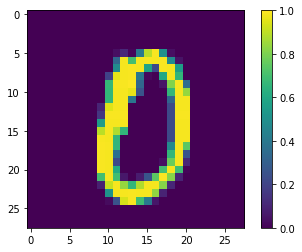

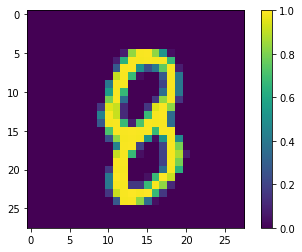

0.0


In [6]:
this_pair = 11
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])
print(ts_labels[this_pair])

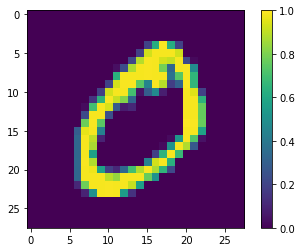

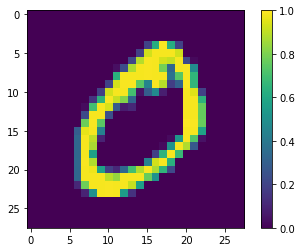

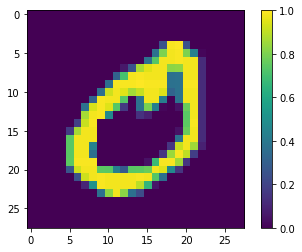

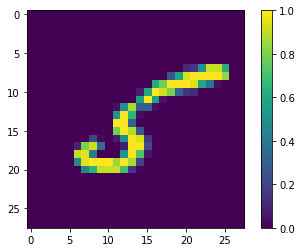

In [7]:
show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

In [8]:
def initialize_base_network():
    input = Input(shape = (28,28,))
    x = Flatten()(input)
    x = Dense(128,activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128,activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128,activation = 'relu')(x)
    
    model = Model(inputs = input , outputs = x)
    return model


def euclidean_distance(vects):
    x , y  =vects
    sum_square = K.sum(K.square(x-y),axis = 1 , keepdims = True)
    return K.sqrt(K.maximum(sum_square,K.epsilon()))

def eucl_shape(shapes):
    shape1 , shape2 = shapes
    return (shape1[0],1)

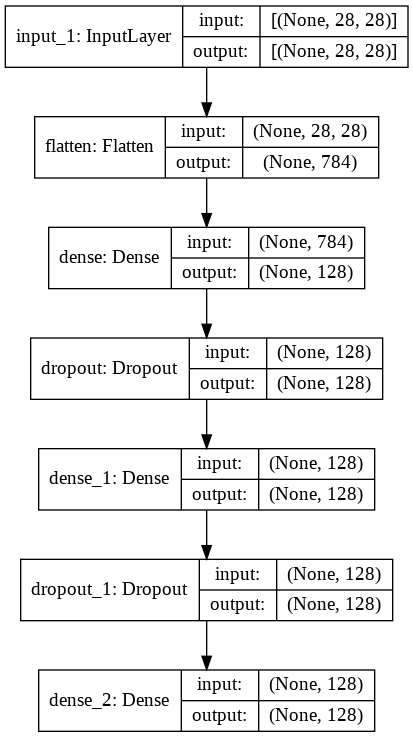

In [9]:
base_network = initialize_base_network()
plot_model(base_network , show_shapes=True, show_layer_names=True, to_file='base-model.png')

In [10]:
input_a = Input(shape = (28,28, ), name = 'left_input')
input_b = Input(shape = (28,28, ), name = 'right_input')
vector_a = base_network(input_a)
vector_b = base_network(input_b)
output =Lambda(euclidean_distance,name = 'output_layer',output_shape = eucl_shape)([vector_a,vector_b])

model = Model(inputs = [input_a,input_b],outputs = output)

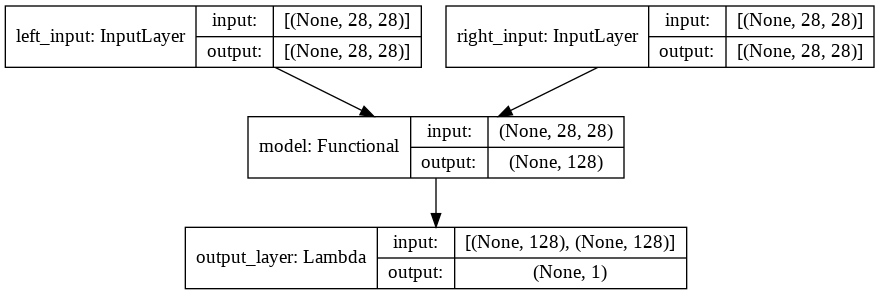

In [11]:
plot_model(model,to_file = 'mod.png' , show_layer_names=True , show_shapes= True)

In [12]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin-y_pred , 0))
        return (y_true*square_pred  + (1-y_true) * margin_square)
    return contrastive_loss

In [13]:
run = wandb.init(project = 'Mnist_Saimese',
                 config = {
                     'learning_rate' : 0.001,
                     'epochs' : 10,
                     'loss' : contrastive_loss_with_margin,
                     'batch_size' : 128,
                     'architecture' : 'Saimese' , 
                     'dataset' : 'Mnist'
                 })
config = wandb.config

In [14]:
rms = RMSprop(config.learning_rate)
model.compile(optimizer = rms , loss = contrastive_loss_with_margin(margin = 1))
history = model.fit([tr_pairs[:,0] , tr_pairs[:,1]] ,tr_labels , validation_data= ([ts_pairs[:,0] , ts_pairs[:,1] ],ts_labels ) , epochs = config.epochs , batch_size = config.batch_size , callbacks = [WandbCallback()])

Epoch 1/10
847/847 [==============================] - 6s 5ms/step - loss: 0.0939 - val_loss: 0.0421
Epoch 2/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0382 - val_loss: 0.0300
Epoch 3/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0272 - val_loss: 0.0266
Epoch 4/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0223 - val_loss: 0.0250
Epoch 5/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0189 - val_loss: 0.0228
Epoch 6/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0170 - val_loss: 0.0231
Epoch 7/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0156 - val_loss: 0.0220
Epoch 8/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0143 - val_loss: 0.0217
Epoch 9/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0134 - val_loss: 0.0231
Epoch 10/10
847/847 [==============================] - 4s 5ms/step - loss: 0.0128 - val_loss: 0.0215

In [15]:
def compute_accuracy(y_true , y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred==y_true)

In [16]:
loss = model.evaluate(x = [ts_pairs[:,0],ts_pairs[:,1]] , y = ts_labels)

y_pred_train  = model.predict([tr_pairs[:,0],tr_pairs[:,1]])
train_acc = compute_accuracy(tr_labels,y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0],ts_pairs[:,1]])
test_acc = compute_accuracy(ts_labels,y_pred_test)

print("Loss : {} , Training Accuracy : {} ,Testing Accuracy : {} ".format(loss,train_acc,test_acc))


557/557 [==============================] - 2s 3ms/step - loss: 0.0215
Loss : 0.021464942023158073 , Training Accuracy : 0.9922232472324723 ,Testing Accuracy : 0.9735129068462401 


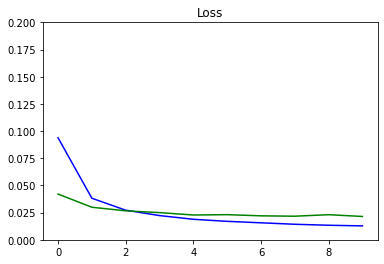

In [17]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [18]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



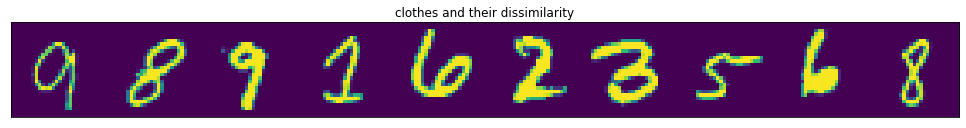

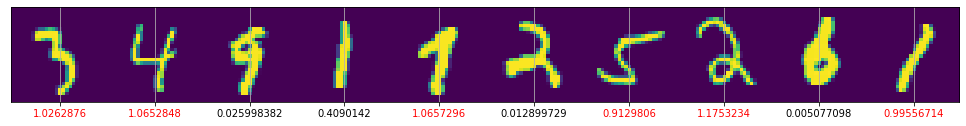

In [19]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_labels[indexes], "clothes and their dissimilarity", 10)